# TropicTaste Inc. - Exotic Fruit Classification with Machine Learning

## Project Overview

**TropicTaste Inc.**, a leading company in the distribution of exotic fruits, aims to improve the efficiency and accuracy of its fruit classification process. The goal is to develop a machine learning model capable of predicting the type of fruit based on numerical features.

Currently, the classification process is manual, prone to human error, and resource-intensive. An automated, accurate system is essential to streamline operations and uphold high quality standards.

## Objectives

By implementing an automated classification model, TropicTaste Inc. seeks to:

- **Improve Operational Efficiency**: Automating the classification process will reduce time and resource consumption, increasing productivity.
- **Reduce Human Error**: A machine learning model will minimize classification errors, ensuring greater accuracy.
- **Optimize Inventory Management**: Accurate classification will enable better inventory control, ensuring optimal storage conditions for each fruit type.
- **Enhance Customer Satisfaction**: Correct identification and classification will help maintain high product quality, boosting customer satisfaction.

## Project Details

### Dataset

The model will use a dataset containing various **numerical features of exotic fruits**, such as weight, size, texture, and color intensity.

### Algorithm

The project will implement the **K-Nearest Neighbors (KNN)** algorithm for classification tasks, leveraging its simplicity and effectiveness in handling structured data.

### Output

The final model will **predict the correct type of fruit** based on the provided input features.

## Project Requirements

### 1. Dataset Preparation

- Load and preprocess the dataset.
- Handle missing values.
- Normalize and scale the data to ensure consistent input for the model.

### 2. KNN Model Implementation

- Develop and train the KNN classification model.
- Optimize hyperparameters (e.g., number of neighbors, distance metrics) to improve predictive performance.

### 3. Model Evaluation

- Use **cross-validation** techniques to assess the model’s generalization capability.
- Calculate key performance metrics such as **accuracy**, **precision**, **recall**, and **classification error**.

### 4. Results Visualization

- Generate visualizations (e.g., confusion matrices, accuracy plots) to analyze and compare model performance.
- Interpret the results to identify areas for further improvement.

---

By integrating machine learning into its operations, TropicTaste Inc. is taking a significant step towards modernizing its processes and maintaining its leadership in the exotic fruit market.


In [47]:
## Download dataset
#!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,log_loss, confusion_matrix



In [49]:
data=pd.read_csv("./fruits.csv",sep=",")

# Print shape and head data
print(data.shape)
data.head()

(500, 6)


,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [50]:
# Check missing values
data.isna().sum()

Frutto                   0
Peso (g)                 0
Diametro medio (mm)      0
Lunghezza media (mm)     0
Durezza buccia (1-10)    0
Dolcezza (1-10)          0
dtype: int64

In [51]:
# We have 5 fruits
print(data["Frutto"].unique())
print(data["Frutto"].value_counts())

['Mela' 'Banana' 'Arancia' 'Uva' 'Kiwi']
Frutto
Mela       100
Banana     100
Arancia    100
Uva        100
Kiwi       100
Name: count, dtype: int64


### Data Visualization
Let's start with a visual exploration of the data

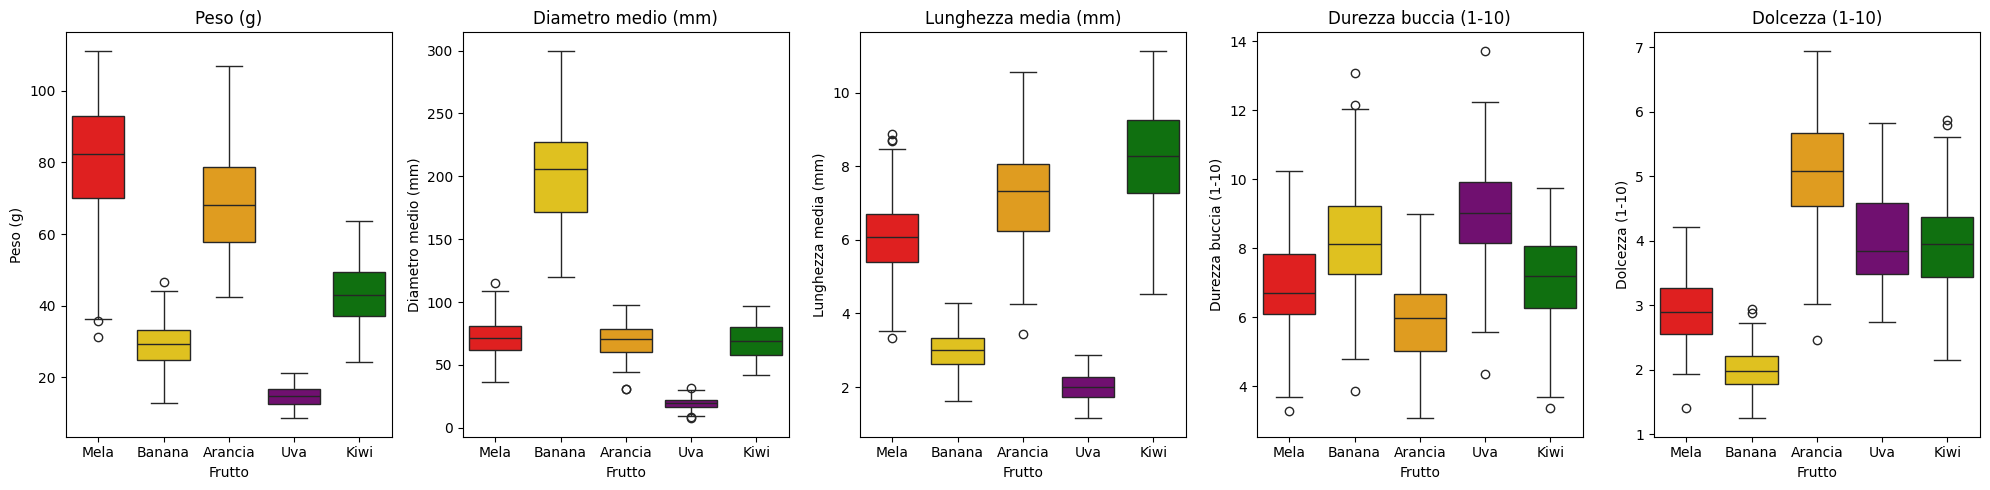

In [52]:
palette_frutti = {
    "Mela": "red",
    "Banana": "gold",
    "Arancia": "orange",
    "Uva": "purple",
    "Kiwi": "green"
}
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, col in enumerate(data.columns[1:]):
    sns.boxplot(x="Frutto", y=col, data=data, 
                ax=axes[i],palette=palette_frutti,hue="Frutto")
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

There are some values that can be considered outliers. Let's create a function to detect the number of outliers for each features

In [53]:
def count_outliers(df, column):
    """ 
    Function to search outliers in a column stratified by group
    Args:
        df : dataframe
        column:column in which you want to search outliers
        group_column : column that specifies Group


    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), outliers

In [54]:
for col in data.columns[1:]:
    n_outlier, _ =count_outliers(data,col)
    print(f"{col} has {n_outlier} values out of range")

Peso (g) has 0 values out of range
Diametro medio (mm) has 96 values out of range
Lunghezza media (mm) has 0 values out of range
Durezza buccia (1-10) has 2 values out of range
Dolcezza (1-10) has 0 values out of range


The results show a conceptual error in our function because it doesn't account for the different groups. Let's rewrite it to also consider the existence of different types of fruits.

In [55]:
def count_outliers_by_group(df, column, group_column):
    """
    Function to search outliers in a column stratified by group
    Args:
        df : dataframe
        column:column in which you want to search outliers
        group_column : column that specifies Group

    
    """
    outliers_by_group = {}
    for group, group_data in df.groupby(group_column):
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = group_data[(group_data[column] < lower_bound) | (group_data[column] > upper_bound)]
        
        outliers_by_group[group] = {
            'outlier_count': len(outliers),
            'outliers': outliers
        }
    total_outliers=sum([outliers_by_group[fruit]['outlier_count'] for fruit in outliers_by_group.keys()])
    return outliers_by_group,total_outliers

In [56]:
for col in data.columns[1:]:
    out,total =count_outliers_by_group(data,col,"Frutto")
    print(f"{col} has {total} values out of range")
    
    #if total>0:
    #    print(out)
    #print("---------------------------")

Peso (g) has 3 values out of range
Diametro medio (mm) has 6 values out of range
Lunghezza media (mm) has 5 values out of range
Durezza buccia (1-10) has 7 values out of range
Dolcezza (1-10) has 6 values out of range


There are some outliers in the data. One option could be to remove them entirely, but in order not to reduce the number of samples, we adopt a different approach: values greater than Q3 + 1.5 * IQR are converted to Q3, and those lower than Q1 - 1.5 * IQR are converted to Q1.

In [62]:
def change_outliers(group, column):
    """
    Apply function by group
    """
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    group[column] = group[column].apply(
        lambda x: Q1 if x < lower_bound else (Q3 if x > upper_bound else x)
    )
    return group


def change_outliers_by_group(df, column, group_col):
    """
    Apply change_outlier function in all column stratified by group
    """
    return df.groupby(group_col, group_keys=False).apply(lambda g: change_outliers(g, column))

In [63]:
for col in data.columns[1:]:  
    data = change_outliers_by_group(data, col, "Frutto")

Let's visualize data after the change of outliers values

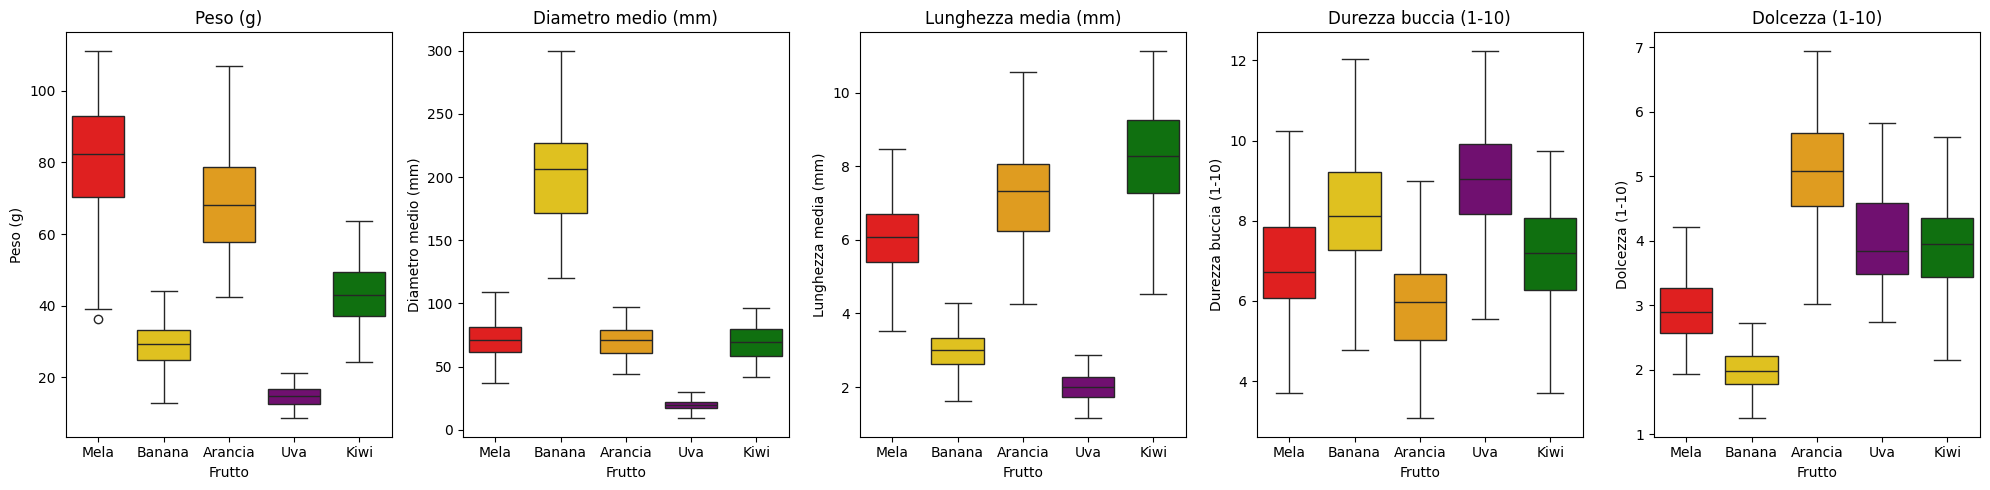

In [64]:
palette_frutti = {
    "Mela": "red",
    "Banana": "gold",
    "Arancia": "orange",
    "Uva": "purple",
    "Kiwi": "green"
}
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, col in enumerate(data.columns[1:]):
    sns.boxplot(x="Frutto", y=col, data=data, 
                ax=axes[i],palette=palette_frutti,hue="Frutto")
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### KNN Model Training

Now, we begin training the model. First, we separate the features from the target variable, which is the fruit class. Then, we split the dataset into training and test sets.

In [ ]:
X = data.iloc[:, 1:]
y = data["Frutto"]

# Train-test split with stratify=y to have a similar proportion of fruits in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


We will try an initial approach by using KNN directly on the data, and then we will apply KNN on the two principal components from PCA. In both cases, it’s important to scale our data before running the models.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Let's try first to train the model without PCA
# We try different values of K for the KNN model
metrics = {}
k_values = range(1, 41)

for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    y_proba = knn.predict_proba(X_test_scaled)
    # Calculate some metrics
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_proba)
    # Store the results in a dictionary
    metrics[k] = {'accuracy': accuracy, 'log_loss': log_loss_value}
    
    #Print results
    print(f"K = {k}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {log_loss_value:.4f}")
    print("--------------------------------------")

K = 1
Accuracy: 0.8500
Log Loss: 5.4065
--------------------------------------
K = 2
Accuracy: 0.8400
Log Loss: 2.2597
--------------------------------------
K = 3
Accuracy: 0.8900
Log Loss: 1.2300
--------------------------------------
K = 4
Accuracy: 0.8500
Log Loss: 0.5451
--------------------------------------
K = 5
Accuracy: 0.9200
Log Loss: 0.5362
--------------------------------------
K = 6
Accuracy: 0.9100
Log Loss: 0.5305
--------------------------------------
K = 7
Accuracy: 0.9200
Log Loss: 0.5313
--------------------------------------
K = 8
Accuracy: 0.8900
Log Loss: 0.5311
--------------------------------------
K = 9
Accuracy: 0.9000
Log Loss: 0.5331
--------------------------------------
K = 10
Accuracy: 0.8900
Log Loss: 0.5382
--------------------------------------
K = 11
Accuracy: 0.9100
Log Loss: 0.5367
--------------------------------------
K = 12
Accuracy: 0.8900
Log Loss: 0.5392
--------------------------------------
K = 13
Accuracy: 0.9100
Log Loss: 0.5433
--------

We can also visualize the accuracy and log loss in function of k

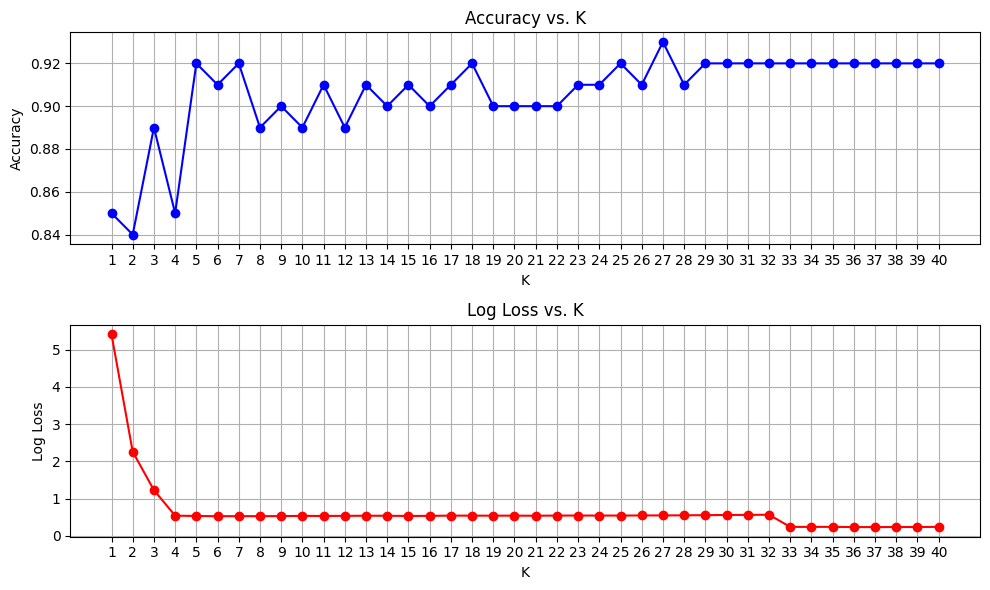

In [ ]:

k_list = list(metrics.keys())
accuracy_list = [metrics[k]['accuracy'] for k in k_list]
log_loss_list = [metrics[k]['log_loss'] for k in k_list]

plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
plt.plot(k_list, accuracy_list, marker='o', color='b', label='Accuracy')
plt.title('Accuracy vs. K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 41, step=1))
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(k_list, log_loss_list, marker='o', color='r', label='Log Loss')
plt.title('Log Loss vs. K')
plt.xlabel('K')
plt.ylabel('Log Loss')
plt.xticks(np.arange(1, 41, step=1))
plt.grid(True)

plt.tight_layout()
plt.show()

The graphs show that the accuracy for the values of K considered (from 1 to 40) ranges from a minimum of 0.84 to a maximum of 0.93. Meanwhile, the log loss drops below 1 starting from K=3, reaches a plateau around K=5, and then decreases further after K=33

We take a look at the confusion matrices to see where the model makes the most errors

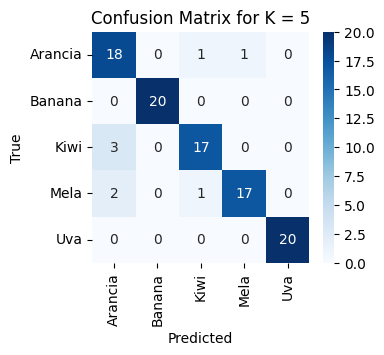

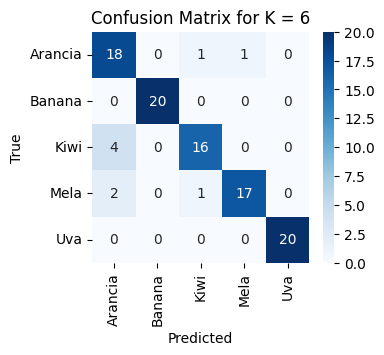

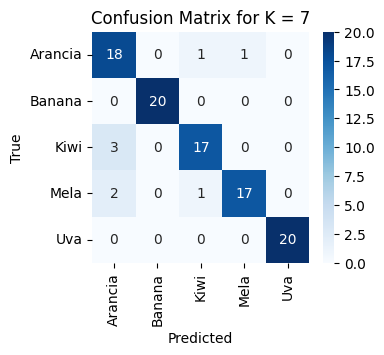

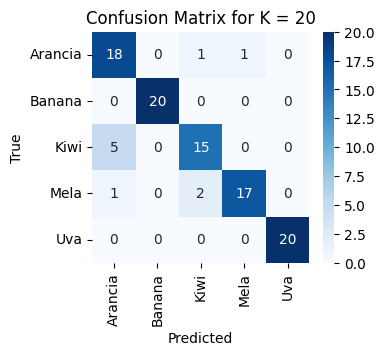

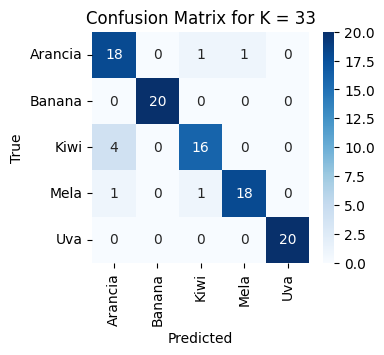

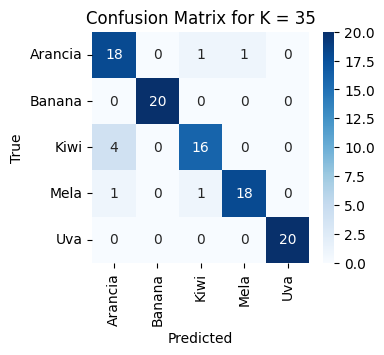

In [ ]:
# We select just a subset of K
k_values = [5,6,7,20,33,35]


for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    y_proba = knn.predict_proba(X_test_scaled)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3.5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for K = {k}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()





The confusion matrices reveal that most classification errors occur among the Orange, Kiwi, and Apple classes. However, these misclassifications tend to decrease as the value of K increases. Referring back to the boxplots, these fruits exhibit similar characteristics in terms of weight and average length, which likely contributes to the model's difficulty in distinguishing them accurately.


### Model training with PCA

Although the dataset contains only a few features, we will try a PCA-based approach, which also allows us to visualize our data points in 2D.

In [ ]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
print("Variance explained", pca.explained_variance_ratio_)


Variance explained [0.45104199 0.27180443 0.1180197 ]


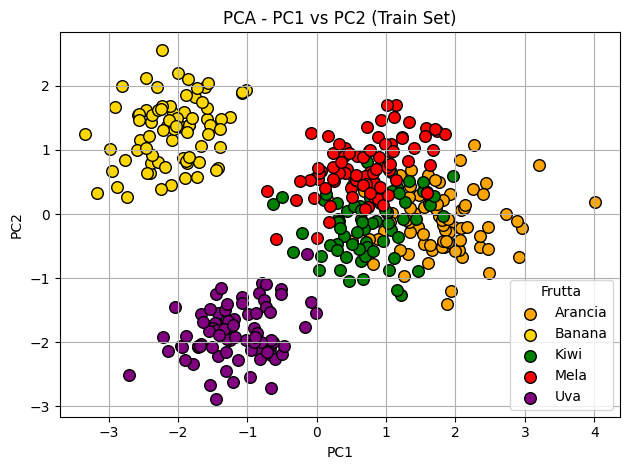

In [ ]:

for fruit in np.unique(y_train):
    idx = np.array(y_train) == fruit
    plt.scatter(
        X_train_pca[idx, 0],
        X_train_pca[idx, 1],
        c=palette_frutti[fruit],
        label=fruit,
        edgecolor='k',
        s=70
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - PC1 vs PC2 (Train Set)')
plt.legend(title="Frutta")
plt.grid(True)
plt.tight_layout()
plt.show()

The PCA results confirm what we had already inferred from the boxplots and the previous model's performance — namely, that the Orange, Kiwi, and Apple classes are quite similar. This is reflected in the PCA projections, where these classes appear very close to each other in the reduced feature space.

In [ ]:
# Apply PCA also to test set
X_test_pca = pca.transform(X_test_scaled)

# We try different values of K for the KNN model
metrics_pca = {}
k_values = range(1, 41)


for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    y_proba = knn.predict_proba(X_test_pca)
    # Calculate some metrics
    accuracy = accuracy_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_proba)
    # Store the results in a dictionary
    metrics_pca[k] = {'accuracy': accuracy, 'log_loss': log_loss_value}
    
    #Print results
    print(f"K = {k}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {log_loss_value:.4f}")
    print("--------------------------------------")

K = 1
Accuracy: 0.8500
Log Loss: 5.4065
--------------------------------------
K = 2
Accuracy: 0.8100
Log Loss: 2.6548
--------------------------------------
K = 3
Accuracy: 0.8400
Log Loss: 2.3414
--------------------------------------
K = 4
Accuracy: 0.8200
Log Loss: 1.3059
--------------------------------------
K = 5
Accuracy: 0.8600
Log Loss: 0.9741
--------------------------------------
K = 6
Accuracy: 0.8700
Log Loss: 0.6219
--------------------------------------
K = 7
Accuracy: 0.8700
Log Loss: 0.6171
--------------------------------------
K = 8
Accuracy: 0.8700
Log Loss: 0.6262
--------------------------------------
K = 9
Accuracy: 0.8600
Log Loss: 0.6443
--------------------------------------
K = 10
Accuracy: 0.8700
Log Loss: 0.3080
--------------------------------------
K = 11
Accuracy: 0.8700
Log Loss: 0.3138
--------------------------------------
K = 12
Accuracy: 0.8700
Log Loss: 0.3131
--------------------------------------
K = 13
Accuracy: 0.8800
Log Loss: 0.3224
--------

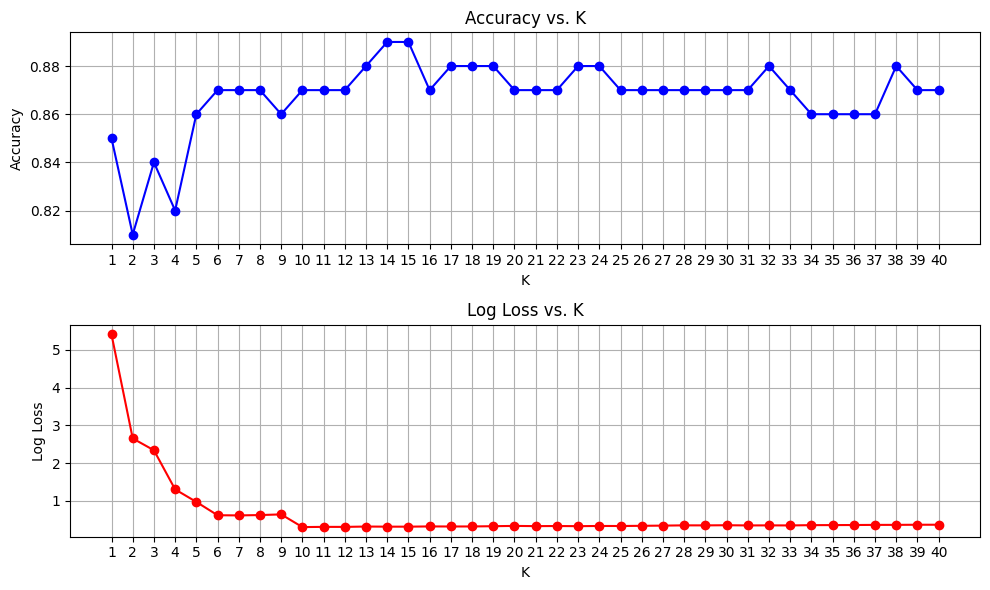

In [ ]:

k_list = list(metrics_pca.keys())
accuracy_list = [metrics_pca[k]['accuracy'] for k in k_list]
log_loss_list = [metrics_pca[k]['log_loss'] for k in k_list]

plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
plt.plot(k_list, accuracy_list, marker='o', color='b', label='Accuracy')
plt.title('Accuracy vs. K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 41, step=1))
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(k_list, log_loss_list, marker='o', color='r', label='Log Loss')
plt.title('Log Loss vs. K')
plt.xlabel('K')
plt.ylabel('Log Loss')
plt.xticks(np.arange(1, 41, step=1))
plt.grid(True)

plt.tight_layout()
plt.show()

The model trained on the PCA-transformed data doesn't perform as well as the one trained on the raw data, especially in terms of accuracy. This is likely because PCA focuses on capturing overall variance, not necessarily the features that best separate the classes. As a result, it struggles to clearly distinguish between similar classes like orange, kiwi, and apple.

### Conclusion

Since the accuracy remains the same and the decrease in log loss is only marginal, it is more reasonable to choose a simpler model with a lower computational cost. Therefore, selecting a K value in the range of 5 to 7 is preferable over using K=33 or higher.